In [29]:
data_dir = '/mnt/c/Users/ferna/Desktop/SingleCell/data/'
# %run -i '../../utils/load_data_short.py'

import sys
sys.path.insert(0, '../../utils/')
import importlib
# importlib.reload(scp)
# importlib.reload(spu)
sns.reset_orig()
from scipy.stats import chisquare
from scipy.stats import combine_pvalues
%run -i '../../utils/Kruskal_Wallis_test_functions.py'

import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings("ignore")

### Kruskal-Wallis test of variance

Here we run the KW test of variance for all observed exons in the Chen, Trapnell and Song datasets. We test if exons show significance changes in splicing between cell types, and plot the distribution of p-values. For this, we have:

* $X$ Matrix of $\hat{\Psi}$ observations
* $M$ Matrix of mRNA counts (and helper matrix-per-event matrix)
* $R$ Matrix of total read counts from which we derive the observations in the $\hat{\Psi}$ matrix.
* $Meta$ Metadata with cluster information

We run the Kruskal-Wallis test for each exon in $X$, testing for significant changes in average splicing rates between the clusters of cells specified in $Meta$.

We select a subset of exons (selected by mRNA) that has a minimum of 10 mRNAs in $M$ and a minimum of theexpected reads from 10 mRNAs in $R$. ANother subset is selected with a flat minimum of 10 reads in $R$ (seected by reads).

It returns: 
* **p-vals** a dataframe with p-value from the KW test for each exon in $M$
* **selected by mRNAs** a list of exons selected by the mRNA filter 
* **selected by reads**  a list of exons selected by the flat 10 read filter

We test if the exons selected by the two approaches are enriched for exons with low p-values from the Kruskal-Wallis test.

intermediate exons: 1117


HBox(children=(IntProgress(value=0, max=1117), HTML(value='')))


not pass: 84
tested exons: 1033


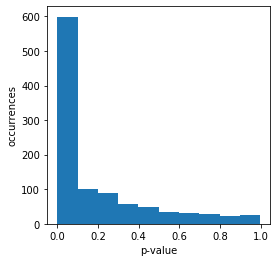

intermediate exons: 809


HBox(children=(IntProgress(value=0, max=809), HTML(value='')))


not pass: 96
tested exons: 713


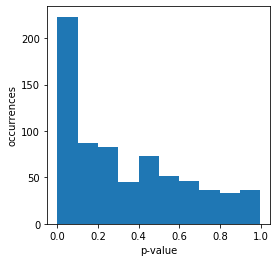

intermediate exons: 896


HBox(children=(IntProgress(value=0, max=896), HTML(value='')))


not pass: 517
tested exons: 379


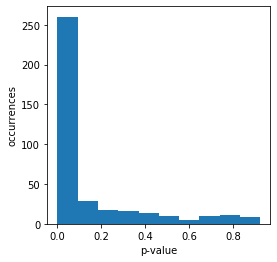

In [2]:
chen_data_out = test_anova_filters(chen_PSI, chen_mrna_counts, mrna_per_event_chen, 
                chen_read_counts, chen_coverage_tab, chen_pca_clust, clusters = 'AC',  psi_min = 0.05, obs_min = 0.5, 
                      mrna_min = 10, mrna_read_min=0, read_min =10, dset_name = 'chen dataset;', correct_multitest = False)

trapnell_data_out = test_anova_filters(trapnell_PSI, trapnell_mrna_counts, mrna_per_event_trapnell, 
                trapnell_read_counts, trapnell_coverage_tab, trapnell_pca_clust, clusters = 'AC',  psi_min = 0.05, obs_min = 0.5, 
                      mrna_min = 10, mrna_read_min=0, read_min =10, dset_name = 'trapnell dataset;', correct_multitest = False)

song_data_out = test_anova_filters(song_PSI, song_mrna_counts, mrna_per_event_song, 
                song_read_counts, song_coverage_tab, song_pca_clust, clusters = 'AC',  psi_min = 0.05, obs_min = 0.5, 
                      mrna_min = 10, mrna_read_min=0, read_min =10, dset_name = 'song dataset;', correct_multitest = False)

### p-value distribution from KW test

We visualize the distribution of p-values from the KW test by comparing it with the expected quantiles of a uniform distribution. We compare 
* The distribution of the p-values of all exons (yellow)
* The distribution of p-values of the exons selected by the mRNA filter (blue)
* The distribution of p-values of the exons selected by the read filter (red)

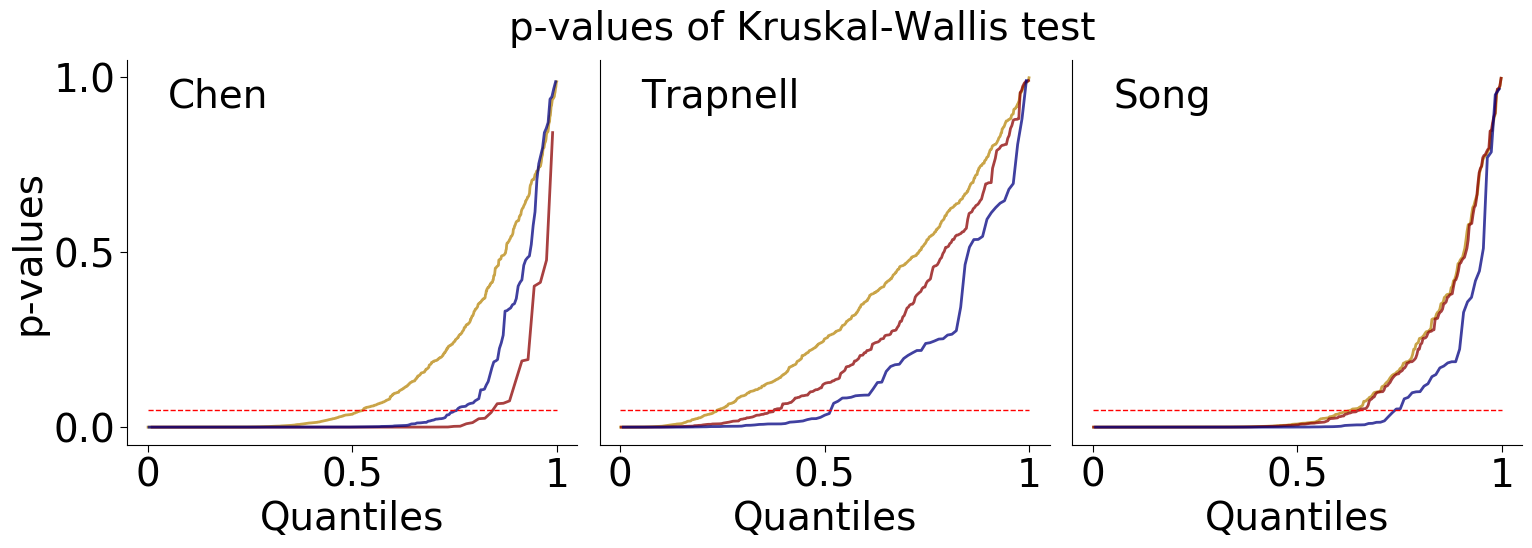

In [14]:
figsize(18, 5)
fig = plt.figure()

fig.suptitle('p-values of Kruskal-Wallis test', fontsize=28)

gs = GridSpec(1,3)
gs.update(wspace=0.05, hspace=1.05)

ax_1 = fig.add_subplot(gs[0,0])
ax_2 = fig.add_subplot(gs[0,1])
ax_3 = fig.add_subplot(gs[0,2])

ax_1.set_ylim((-0.05,1.05))
ax_2.set_ylim((-0.05,1.05))
ax_3.set_ylim((-0.05,1.05))

plot_pvalues(ax_1, chen_data_out)
plot_pvalues(ax_2, trapnell_data_out)
plot_pvalues(ax_3, song_data_out)

plt.setp(ax_2.get_yticklabels(), visible=False)
plt.setp(ax_3.get_yticklabels(), visible=False)
ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')

ax_1.text(0.05, 1, 'Chen', fontsize=28, verticalalignment='top')
ax_2.text(0.05, 1, 'Trapnell', fontsize=28, verticalalignment='top')
ax_3.text(0.05, 1, 'Song', fontsize=28, verticalalignment='top')

ax_1.set_ylabel('p-values', fontsize = 28)

# plt.savefig('plots_review/figure3/anova/pvalues_3sets.svg', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/anova/pvalues_3sets.pdf', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/anova/pvalues_3sets.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

### Enrichment of significant exons
Test if the exons selected by the mRNA-based filter, and the flat 10-read filter, are enriched for exons with low p-value in the KW test.

For each low-pvalue score $x$, we estimate the fold enrichment of a set of selected exons as:

$$\text{fold enrichment} = \frac{M\cdot k}{N\cdot n}$$

Where $M$ is the total number of exons tested; $N$ is the number of exons selected by the filter; $n$ is the total number of exons with KW p-value $\leq x$; and $k$ are the selected exons with p-value $\leq x$.

The enrichment p-value is calculated with the hypergeometric test, and adjusted for multiple testing with the Benjamini Hochberg method.

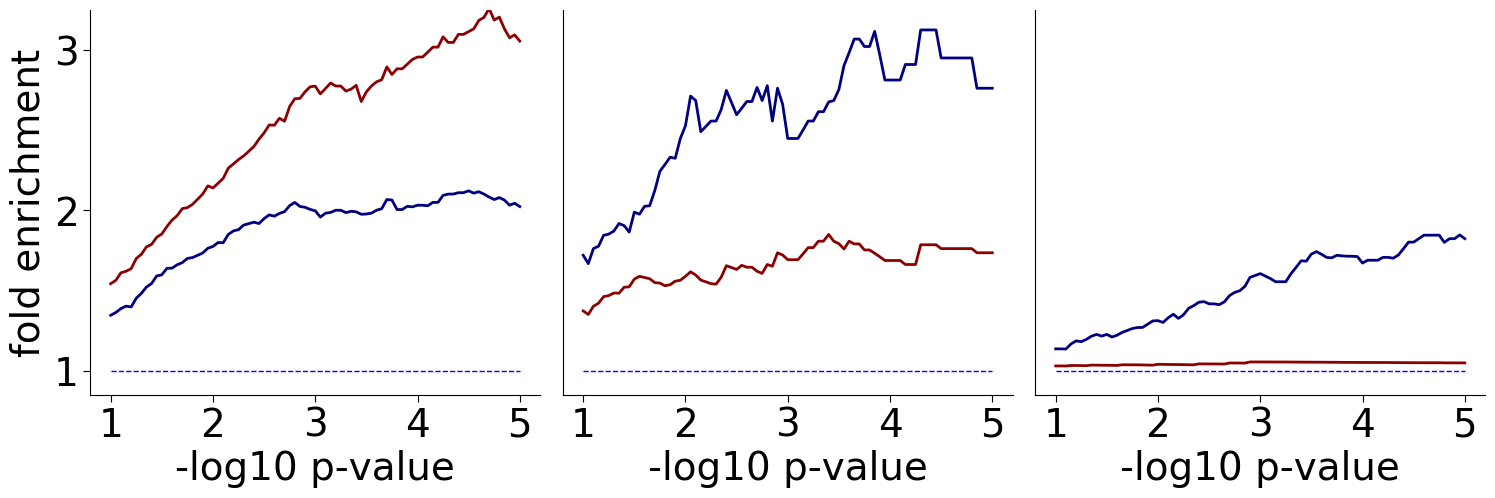

In [32]:
# Get fold enrichment and enrichment significance of sets of selected exons
chen_enrichment = get_enrichment(chen_data_out)
trapnell_enrichment = get_enrichment(trapnell_data_out)
song_enrichment = get_enrichment(song_data_out)
    
figsize(18, 5)
fig = plt.figure()
gs = GridSpec(1,3)
gs.update(wspace=0.05, hspace=1.05)
ax_1 = fig.add_subplot(gs[0,0])
ax_2 = fig.add_subplot(gs[0,1])
ax_3 = fig.add_subplot(gs[0,2])
ax_1.set_ylim((0.85,3.25))
ax_2.set_ylim((0.85,3.25))
ax_3.set_ylim((0.85,3.25))
plot_filter_lines(ax_1, chen_enrichment[0], chen_enrichment[1], chen_enrichment[2])
plot_filter_lines(ax_2, trapnell_enrichment[0], trapnell_enrichment[1], trapnell_enrichment[2])
plot_filter_lines(ax_3, song_enrichment[0], song_enrichment[1], song_enrichment[2])
plt.setp(ax_2.get_yticklabels(), visible=False)
plt.setp(ax_3.get_yticklabels(), visible=False)
ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_1.plot([1, 5], [1, 1], 'b--', linewidth=1)
ax_2.plot([1, 5], [1, 1], 'b--', linewidth=1)
ax_3.plot([1, 5], [1, 1], 'b--', linewidth=1)
ax_1.set_ylabel('fold enrichment', fontsize = 28)

plt.savefig('plots_review/figure3/anova/enrichment_3sets.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure3/anova/enrichment_3sets.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure3/anova/enrichment_3sets.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

### Enrichment significance

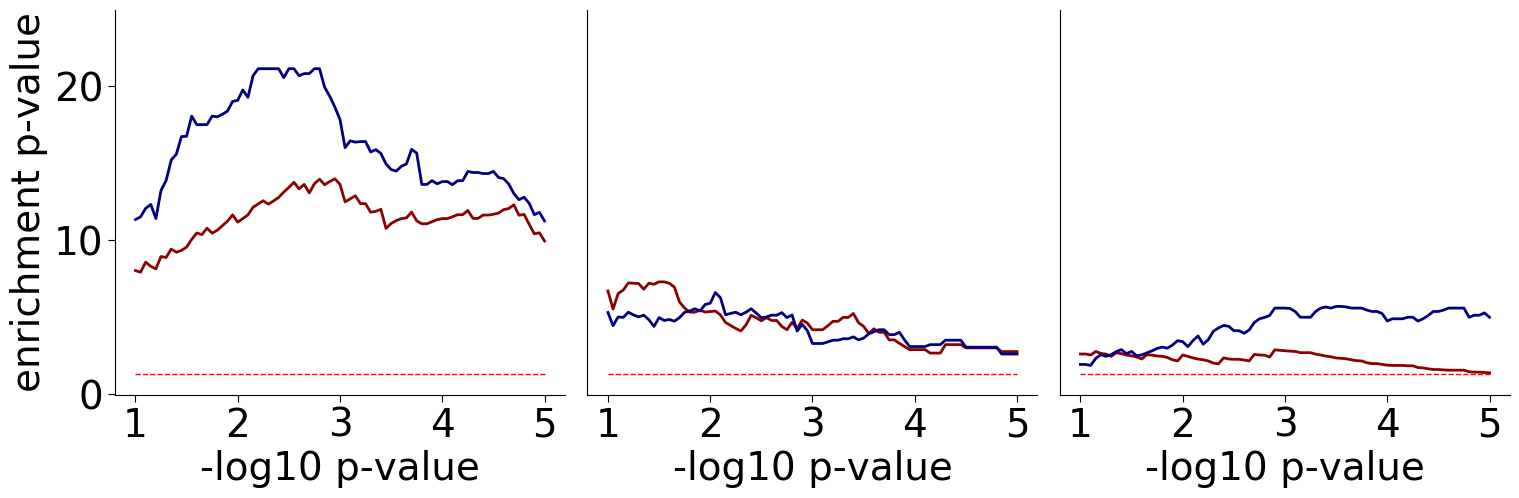

In [33]:
figsize(18, 5)
fig = plt.figure()
gs = GridSpec(1,3)
gs.update(wspace=0.05, hspace=1.05)
ax_1 = fig.add_subplot(gs[0,0])
ax_2 = fig.add_subplot(gs[0,1])
ax_3 = fig.add_subplot(gs[0,2])
ax_1.set_ylim((-0.05,25))
ax_2.set_ylim((-0.05, 25))
ax_3.set_ylim((-0.05, 25))
plot_filter_lines(ax_1, -np.log10(chen_enrichment[3]), 
                  -np.log10(chen_enrichment[4]), -np.log10(chen_enrichment[5]))
plot_filter_lines(ax_2, -np.log10(trapnell_enrichment[3]), 
                  -np.log10(trapnell_enrichment[4]), -np.log10(trapnell_enrichment[5]))
plot_filter_lines(ax_3, -np.log10(song_enrichment[3]), 
                  -np.log10(song_enrichment[4]), -np.log10(song_enrichment[5]))
ax_1.plot([1, 5], -np.log10([0.05, 0.05]), 'r--', linewidth=1)
ax_2.plot([1, 5], -np.log10([0.05, 0.05]), 'r--', linewidth=1)
ax_3.plot([1, 5], -np.log10([0.05, 0.05]), 'r--', linewidth=1)
plt.setp(ax_2.get_yticklabels(), visible=False)
plt.setp(ax_3.get_yticklabels(), visible=False)
ax_2.yaxis.set_ticks_position('none')
ax_3.yaxis.set_ticks_position('none')
ax_1.set_ylabel('enrichment p-value', fontsize = 28)

plt.savefig('plots_review/figure3/anova/enrichment_pvals_3sets.svg', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure3/anova/enrichment_pvals_3sets.pdf', bbox_inches='tight', transparent=True)
plt.savefig('plots_review/figure3/anova/enrichment_pvals_3sets.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

### Other statistics to evaluate the filters

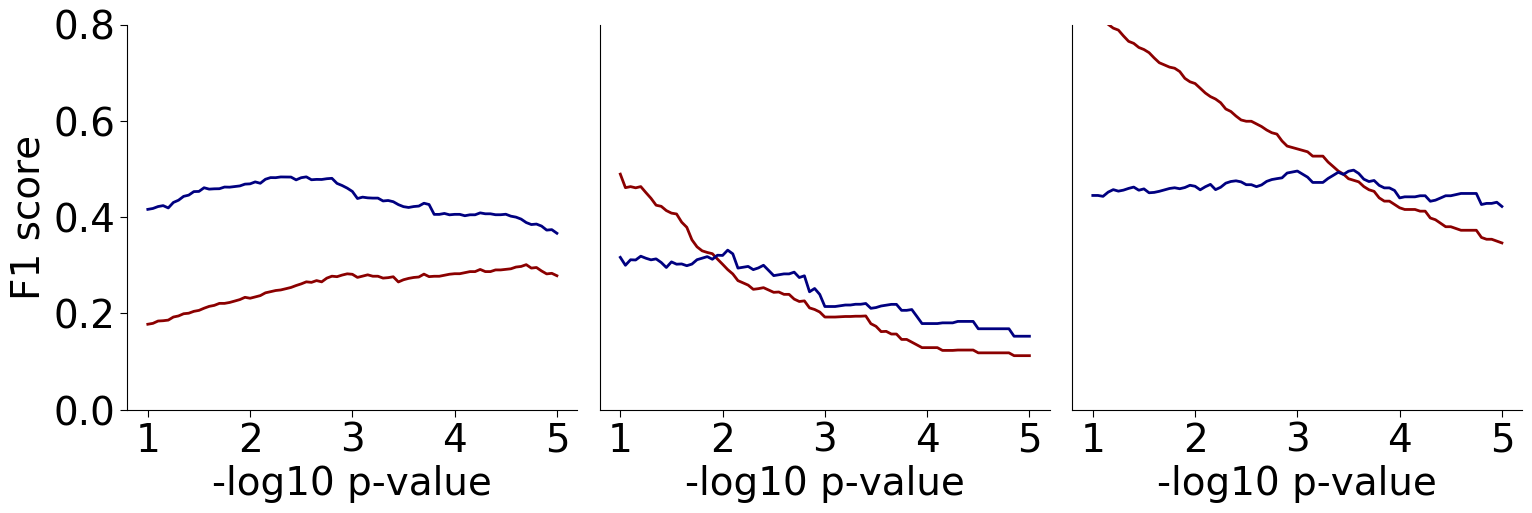

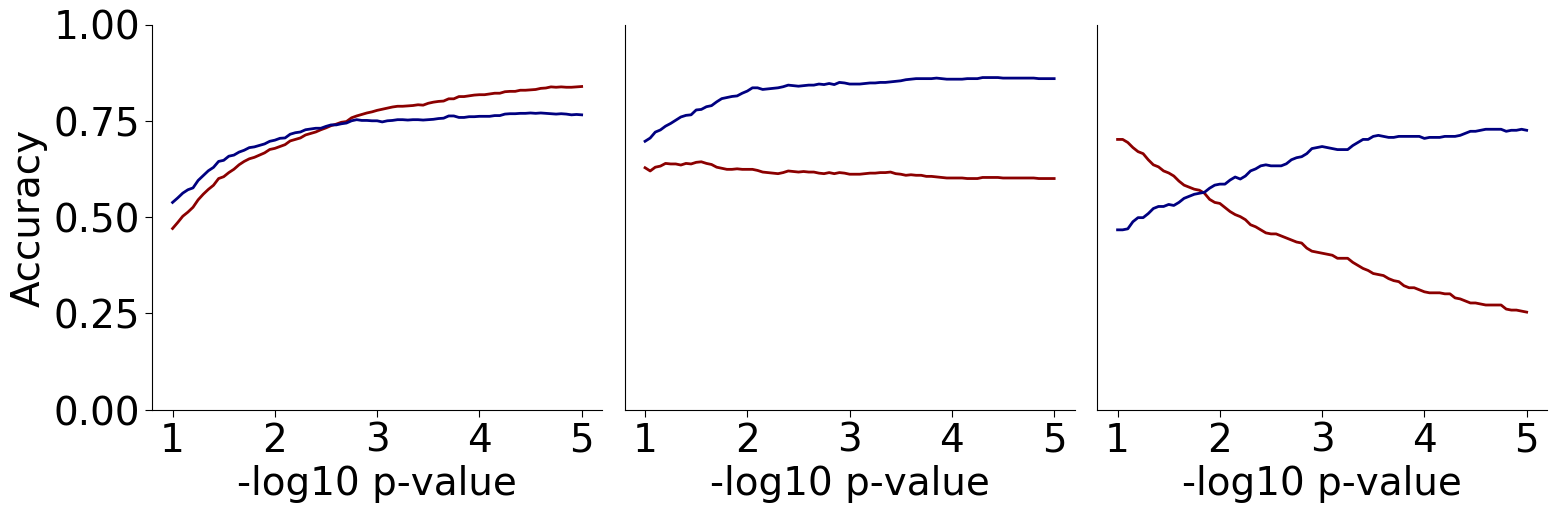

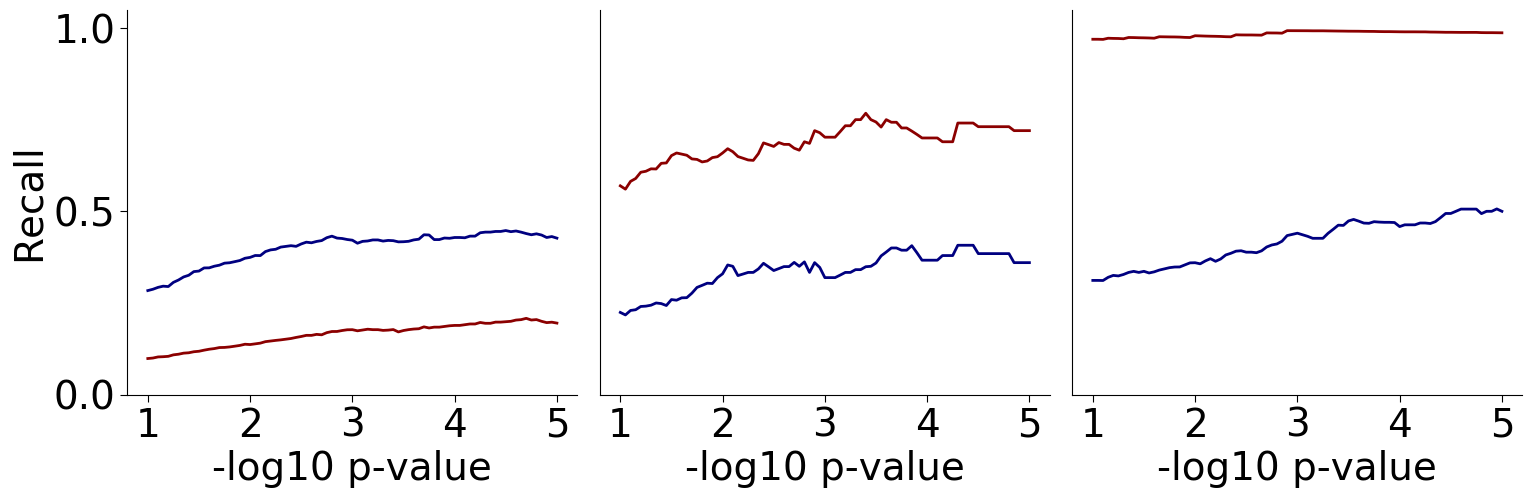

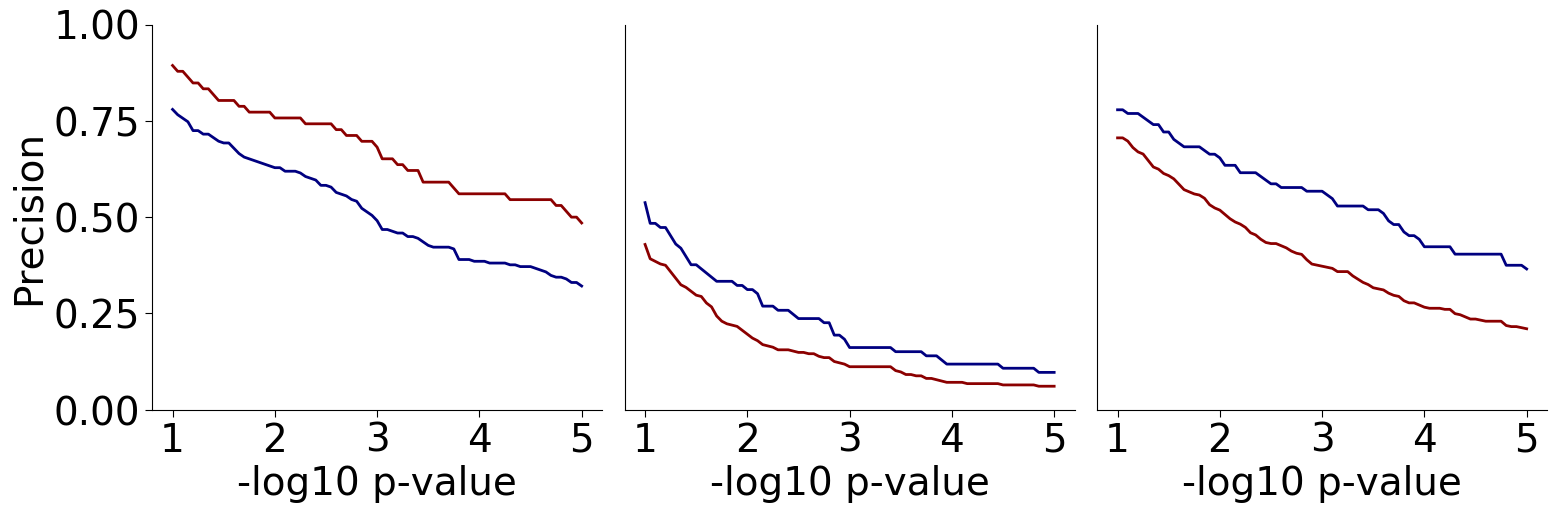

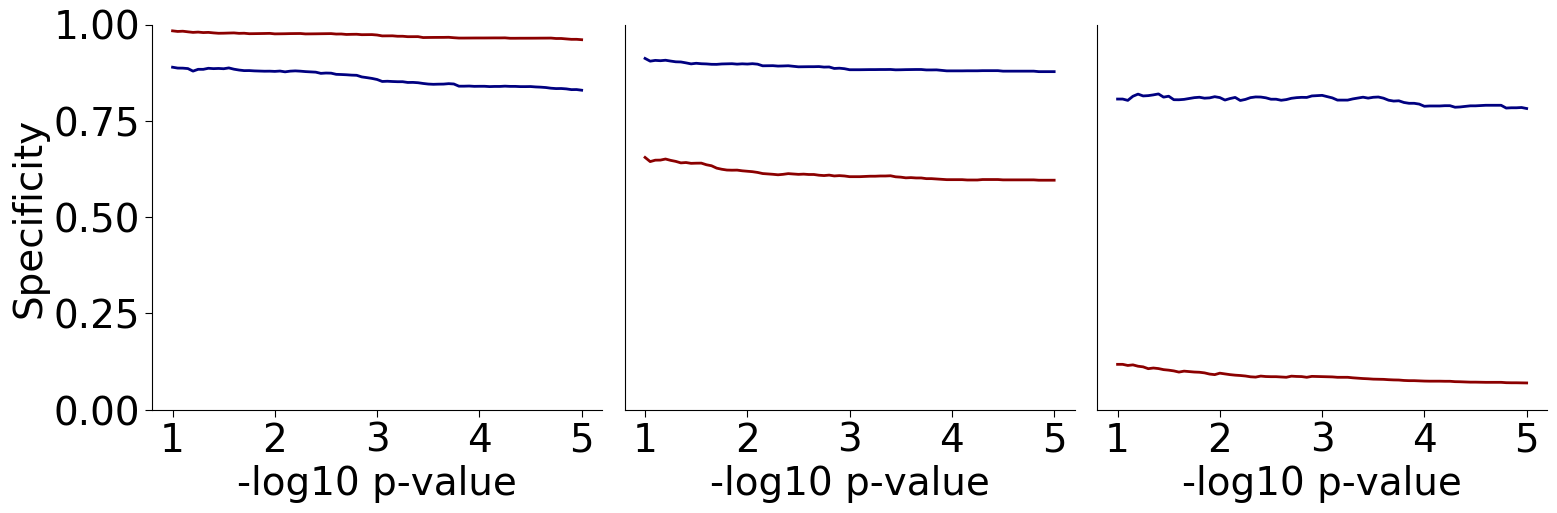

In [24]:
plot_dset_curves(chen_data_out, trapnell_data_out, song_data_out, 
                     which_curve = 3, p_max = 0.1, p_min = 0.00001, steps = 0.05, ylims=(0, 0.8))

plot_dset_curves(chen_data_out, trapnell_data_out, song_data_out, 
                     which_curve = -2, p_max = 0.1, p_min = 0.00001, steps = 0.05, ylims=(0, 1))

plot_dset_curves(chen_data_out, trapnell_data_out, song_data_out, 
                     which_curve = 0, p_max = 0.1, p_min = 0.00001, steps = 0.05, ylims=(0, 1.05))

plot_dset_curves(chen_data_out, trapnell_data_out, song_data_out, 
                     which_curve = 1, p_max = 0.1, p_min = 0.00001, steps = 0.05, ylims=(0, 1))

plot_dset_curves(chen_data_out, trapnell_data_out, song_data_out, 
                     which_curve = 2, p_max = 0.1, p_min = 0.00001, steps = 0.05, ylims=(0, 1))

### Total number of significant exons in each dataset for a given p-value

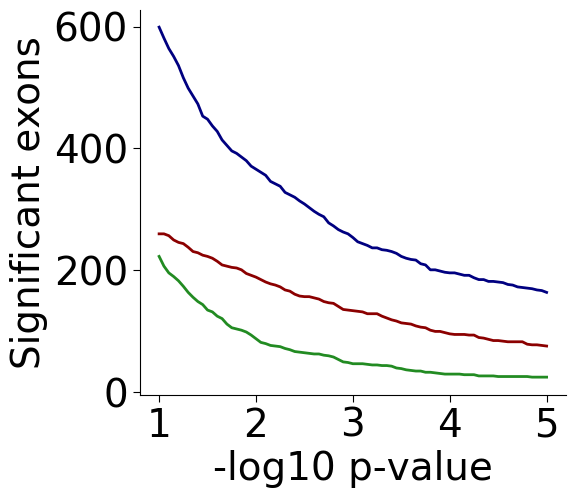

In [25]:
figsize(5.5, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)
chen_linea = []
trapnell_linea = []
song_linea = []
p_limits = 10**(-np.arange(-np.log10(0.1), -np.log10(0.00001)+0.05, 0.05))
for x in p_limits:
    chen_linea.append(np.sum(chen_data_out[0] <= x))
    trapnell_linea.append(np.sum(trapnell_data_out[0] <= x))
    song_linea.append(np.sum(song_data_out[0] <= x))
    
ax.plot(np.arange(-np.log10(0.1), -np.log10(0.00001)+0.05, 0.05), chen_linea, linewidth=2, c='navy')
ax.plot(np.arange(-np.log10(0.1), -np.log10(0.00001)+0.05, 0.05), trapnell_linea, linewidth=2, c='forestgreen')
ax.plot(np.arange(-np.log10(0.1), -np.log10(0.00001)+0.05, 0.05), song_linea, linewidth=2, c='darkred')
ax.set_ylabel('Significant exons', fontsize = 28)
ax.set_xlabel('-log10 p-value', fontsize=28)
ax.tick_params(labelsize=28, length=5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)
xticks = [1, 2, 3, 4, 5]
ax.set_xticks(xticks)
ax.set_xticklabels([str(i) for i in xticks])

# plt.savefig('plots_review/figure3/anova/significant_exons_3sets.svg', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/anova/significant_exons_3sets.pdf', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/anova/significant_exons_3sets.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

### Percent of exons in each dataset that are significant for a given p-value

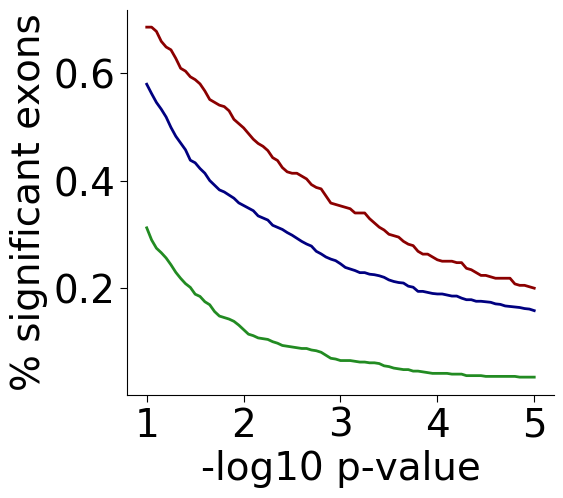

In [26]:
figsize(5.5, 5)

fig = plt.figure()
ax  = plt.subplot(1,1,1)

chen_linea = []
trapnell_linea = []
song_linea = []
p_limits = 10**(-np.arange(-np.log10(0.1), -np.log10(0.00001)+0.05, 0.05))
for x in p_limits:
    chen_linea.append(np.sum(chen_data_out[0] <= x)/len(chen_data_out[0]))
    trapnell_linea.append(np.sum(trapnell_data_out[0] <= x)/len(trapnell_data_out[0]))
    song_linea.append(np.sum(song_data_out[0] <= x)/len(song_data_out[0]))
    
ax.plot(np.arange(-np.log10(0.1), -np.log10(0.00001)+0.05, 0.05), chen_linea, linewidth=2, c='navy')
ax.plot(np.arange(-np.log10(0.1), -np.log10(0.00001)+0.05, 0.05), trapnell_linea, linewidth=2, c='forestgreen')
ax.plot(np.arange(-np.log10(0.1), -np.log10(0.00001)+0.05, 0.05), song_linea, linewidth=2, c='darkred')
ax.set_ylabel('% significant exons', fontsize = 28)
ax.set_xlabel('-log10 p-value', fontsize=28)
ax.tick_params(labelsize=28, length=5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=28, length=5)
xticks = [1, 2, 3, 4, 5]
ax.set_xticks(xticks)
ax.set_xticklabels([str(i) for i in xticks])

# plt.savefig('plots_review/figure3/anova/significant_exons_3sets.svg', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/anova/significant_exons_3sets.pdf', bbox_inches='tight', transparent=True)
# plt.savefig('plots_review/figure3/anova/significant_exons_3sets.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

### Deprecated

In [9]:
# chen_hyper_results = run_hypergeom_test(chen_data_out)
# # lescroart_hyper_results = run_hypergeom_test(lescroart_data_out)
# trapnell_hyper_results = run_hypergeom_test(trapnell_data_out)
# song_hyper_results = run_hypergeom_test(song_data_out)


# total_M = [chen_hyper_results[0]]*3 + [lescroart_hyper_results[0]]*3 + [trapnell_hyper_results[0]]*3 + [song_hyper_results[0]]*3
# total_n = [chen_hyper_results[1]]*3 + [lescroart_hyper_results[1]]*3 + [trapnell_hyper_results[1]]*3 + [song_hyper_results[1]]*3
# total_N = chen_hyper_results[2] + lescroart_hyper_results[2] + trapnell_hyper_results[2] + song_hyper_results[2]
# total_k = chen_hyper_results[3] + lescroart_hyper_results[3] + trapnell_hyper_results[3] + song_hyper_results[3]
# total_pvals = chen_hyper_results[4] + lescroart_hyper_results[4] + trapnell_hyper_results[4] + song_hyper_results[4]
# corrected_pvals = multipletests(total_pvals, method='fdr_bh')[1]

# hyper_table = pd.DataFrame()
# hyper_table['Dataset'] = ['Chen']*3 + ['Lescroart']*3 + ['Trapnell']*3 + ['Song']*3
# hyper_table['Total exons'] = total_M
# hyper_table['Significant change'] = total_n
# hyper_table['Proportion'] = np.array(total_n)/np.array(total_M)
# hyper_table['Filter'] = ['reads', 'mRNA only', 'mRNA']*4
# hyper_table['Total selected'] = total_N
# hyper_table['Significant selected'] = total_k
# hyper_table['Proportion selected'] = np.array(total_k)/np.array(total_N)
# hyper_table['Fold enrichment'] = hyper_table['Proportion selected'] / hyper_table['Proportion']
# hyper_table['p-values'] = total_pvals
# hyper_table['adjusted p-values'] = corrected_pvals

intermediate exons: 260


HBox(children=(IntProgress(value=0, max=260), HTML(value='')))


not pass: 4
tested exons: 256


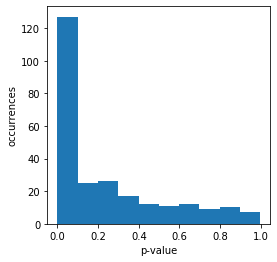

../../utils/Kruskal_Wallis_test_functions.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  N: Sample size (exons selected)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([0.27189012, 0.09260026, 0.04137458, 0.03152349, 0.02955327,
        0.00591065, 0.00394044, 0.00591065, 0.00591065, 0.00394044]),
 array([1.38290215e-03, 2.03161483e+00, 4.06184677e+00, 6.09207870e+00,
        8.12231063e+00, 1.01525426e+01, 1.21827745e+01, 1.42130064e+01,
        1.62432384e+01, 1.82734703e+01, 2.03037022e+01]),
 <a list of 10 Patch objects>)

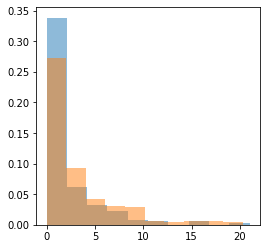

In [10]:
chen_int_genes, chen_int_exons = spu.get_int_events(chen_PSI, chen_mrna_counts, 0.05)
chen_int_exons = [x for x in chen_int_exons if x in mrna_per_event_chen.index]
chen_filtered_lax = filter_psi(chen_PSI, chen_int_exons, mrna_per_event_chen, chen_coverage_tab['SJ_coverage'], 
                           chen_read_counts, mrna_min=10, reads_min=0, cell_min=0.05)

int_genes, int_exons = spu.get_int_events(chen_PSI, chen_mrna_counts, 0.2)
observed_exons = chen_PSI.index[chen_PSI.isna().mean(axis=1) <= (1-0.5)]
test_exons = [x for x in observed_exons if x in int_exons]
chen_selected_mrna = [x for x in chen_filtered_lax[0].index[chen_filtered_lax[0].isna().mean(axis=1) <= 0.9] if x in test_exons]

chen_data_filt = test_anova_filters(chen_filtered_lax[0].loc[chen_selected_mrna], chen_mrna_counts, mrna_per_event_chen, 
                chen_read_counts, chen_coverage_tab, chen_pca_clust, clusters = 'AC',  psi_min = 0.05, obs_min = 0.005, 
                      mrna_min = 10, mrna_read_min=0, read_min =10, dset_name = 'chen dataset;', correct_multitest = False)

plt.hist(-np.log10(chen_data_filt[0].pvals), alpha=0.5, density=True)
plt.hist(-np.log10(chen_data_out[0].loc[chen_data_filt[0].index].pvals), alpha=0.5, density=True)